In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
import torch
from math import floor

path_2 = './part_2'

## Initial Data Load

In [376]:
assets = pd.read_csv(path_2 + '/assets.csv')
collects = pd.read_csv(path_2 + '/collects.csv')

In [377]:
assets['sensors'] = assets['sensors'].str[2:-2]
assets = assets.rename(columns={'sensors':'sensorId'})
assets['createdAt'] = pd.to_datetime(assets['createdAt']).dt.tz_localize(None)
assets.head()

,_id,company,createdAt,description,model,modelType,name,sensorId,specifications.axisX,specifications.axisY,specifications.axisZ,specifications.maxDowntime,specifications.maxTemp,specifications.power,specifications.rpm,specifications.workdays
0,602fac7228aba1048d473cc4,5fb2c4eb1369a4325dc4545f,2021-02-19 12:17:54.457,NaN,60241102ed8ef30e9d309af9,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,IAJ9206,vertical,horizontal,axial,48.00,NaN,3.7,1735.0,NaN
1,5fd0e297bf7d581c1823b8e4,5fbbadeb82a6b901c26df618,2020-12-09 14:43:35.168,NaN,5fd0cf96bf7d581c1823b4c4,heaterFurnace,RDF-61.1,LZY4270,axial,vertical,horizontal,0.25,55.0,0.0,1740.0,NaN
2,5fb286de1369a4325dc45433,5f6b83e34dd69d4bc799ea1f,2020-11-16 14:04:14.564,-,5fb275981369a4325dc4542e,transformer,TRANSFORMADOR 500 KVA N°1,MUR8453,horizontal,vertical,NaN,NaN,65.0,NaN,NaN,NaN
3,6023fad9ed8ef30e9d30952b,5fb2c4eb1369a4325dc4545f,2021-02-10 15:25:13.265,NaN,6023f7dced8ef30e9d30945f,pump,Motor Bomba - Tanque de Expansão Tubo Verde,MXK6435,horizontal,axial,vertical,48.00,NaN,7.0,3525.0,NaN
4,5ff71a150b6abb7be05083b0,5f17203f640a00cc08cb1b3d,2021-01-07 14:26:29.726,NaN,5ff5a854adacd8372cf06950,pump,CAG1- BAGS.12- Motor,MYD8706,horizontal,axial,vertical,NaN,NaN,30.0,1765.0,NaN


In [378]:
assets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   _id                         10 non-null     object        
 1   company                     10 non-null     object        
 2   createdAt                   10 non-null     datetime64[ns]
 3   description                 3 non-null      object        
 4   model                       10 non-null     object        
 5   modelType                   10 non-null     object        
 6   name                        10 non-null     object        
 7   sensorId                    10 non-null     object        
 8   specifications.axisX        8 non-null      object        
 9   specifications.axisY        8 non-null      object        
 10  specifications.axisZ        7 non-null      object        
 11  specifications.maxDowntime  6 non-null      float64       
 1

In [379]:
collects = collects.rename(columns={'createdAt':'created'})
collects = collects.drop_duplicates('_id')
collects['created'] = pd.to_datetime(collects['created']).dt.tz_localize(None)
collects.head()

,_id,created,params.accelRMS.x,params.accelRMS.y,params.accelRMS.z,params.duration,params.sampRate,params.timeStart,params.velRMS.x,params.velRMS.y,params.velRMS.z,sensorId,temp
0,60b57955f77013684c413e39,2021-06-01 00:03:33.370,0.010463,0.004463,0.011677,3.006,1656.686627,1.622506e+09,0.000511,0.000176,0.000289,IAJ9206,23.94
1,60b57c53f77013684c41409f,2021-06-01 00:16:19.173,0.011437,0.004983,0.011482,3.006,1656.686627,1.622507e+09,0.000633,0.000238,0.000292,IAJ9206,23.19
2,60b57f34f77013684c4142cd,2021-06-01 00:28:36.553,0.010494,0.005024,0.011120,3.006,1656.686627,1.622507e+09,0.000524,0.000226,0.000246,IAJ9206,22.50
3,60b58237f77013684c41450c,2021-06-01 00:41:27.622,0.009859,0.004786,0.011096,3.006,1656.686627,1.622508e+09,0.000437,0.000220,0.000248,IAJ9206,22.87
4,60b58515f77013684c414765,2021-06-01 00:53:41.450,0.010014,0.005213,0.011332,3.006,1656.686627,1.622509e+09,0.000501,0.000251,0.000275,IAJ9206,22.56


In [380]:
collects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33901 entries, 0 to 33900
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _id                33901 non-null  object        
 1   created            33901 non-null  datetime64[ns]
 2   params.accelRMS.x  33441 non-null  float64       
 3   params.accelRMS.y  33441 non-null  float64       
 4   params.accelRMS.z  33441 non-null  float64       
 5   params.duration    33441 non-null  float64       
 6   params.sampRate    33441 non-null  float64       
 7   params.timeStart   33441 non-null  float64       
 8   params.velRMS.x    33441 non-null  float64       
 9   params.velRMS.y    33441 non-null  float64       
 10  params.velRMS.z    33441 non-null  float64       
 11  sensorId           33901 non-null  object        
 12  temp               33901 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 3.

In [381]:
print(assets['sensorId'].unique())
print(collects['sensorId'].unique())

['IAJ9206' 'LZY4270' 'MUR8453' 'MXK6435' 'MYD8706' 'MYS2071' 'MZU6388'
 'NAH4736' 'NAI1549' 'NEW4797']
['IAJ9206' 'LZY4270' 'MUR8453' 'MXK6435' 'MYD8706' 'MYS2071' 'MZU6388'
 'NAH4736' 'NAI1549' 'NEW4797']


In [382]:
full_df = collects.merge(assets, how='left', on='sensorId')
full_df.head()

,_id_x,created,params.accelRMS.x,params.accelRMS.y,params.accelRMS.z,params.duration,params.sampRate,params.timeStart,params.velRMS.x,params.velRMS.y,...,modelType,name,specifications.axisX,specifications.axisY,specifications.axisZ,specifications.maxDowntime,specifications.maxTemp,specifications.power,specifications.rpm,specifications.workdays
0,60b57955f77013684c413e39,2021-06-01 00:03:33.370,0.010463,0.004463,0.011677,3.006,1656.686627,1.622506e+09,0.000511,0.000176,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
1,60b57c53f77013684c41409f,2021-06-01 00:16:19.173,0.011437,0.004983,0.011482,3.006,1656.686627,1.622507e+09,0.000633,0.000238,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
2,60b57f34f77013684c4142cd,2021-06-01 00:28:36.553,0.010494,0.005024,0.011120,3.006,1656.686627,1.622507e+09,0.000524,0.000226,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
3,60b58237f77013684c41450c,2021-06-01 00:41:27.622,0.009859,0.004786,0.011096,3.006,1656.686627,1.622508e+09,0.000437,0.000220,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
4,60b58515f77013684c414765,2021-06-01 00:53:41.450,0.010014,0.005213,0.011332,3.006,1656.686627,1.622509e+09,0.000501,0.000251,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN


## Organizing assets data

In [383]:
class Asset:
    def __init__(self, df, row):
        self.sensorID = row['sensorId']
        self.company = row['company']
        self.description = row['description']
        self.model = row['model']
        self.modelType = row['modelType']
        self.name = row['name']
        self.axisX = row['specifications.axisX']
        self.axisY = row['specifications.axisY']
        self.axisZ = row['specifications.axisZ']
        self.maxDowntime = row['specifications.maxDowntime']
        self.maxTemp = row['specifications.maxTemp']
        self.power = row['specifications.power']
        self.rpm = row['specifications.rpm']
        self.power = row['specifications.power']
        self.workdays = row['specifications.workdays']
        
        self.df = self.setData(df)

        self.calcDownTime()
        if False:
            self.plotData()

    def setData(self, df):
        df = df[df['sensorId'] == self.sensorID].sort_values(by='created')
        df['delta_created'] = df['created'].diff(-1)
        df['delta_created'] = df['delta_created'].dt.total_seconds()*-1
        df['time_s'] = df['created']-df['created'].min()
        df['time_s'] = df['time_s'].dt.total_seconds()
        df['time_s_2'] = df['params.timeStart'] - df['params.timeStart'].min()
        df[[
            'params.accelRMS.x',
            'params.accelRMS.y',
            'params.accelRMS.z',
            'params.velRMS.x',
            'params.velRMS.y',
            'params.velRMS.z']] = df[[
            'params.accelRMS.x',
            'params.accelRMS.y',
            'params.accelRMS.z',
            'params.velRMS.x',
            'params.velRMS.y',
            'params.velRMS.z'
            ]].fillna(np.nan)
        df['time_s_3'] = df['time_s_2']
        df['time_s_2'] = df['time_s_2'].fillna(df['time_s'])
        df = df.reset_index(drop=True)
        return df
    
    def plotData(self):
        details = '\
        company: {}\n\
        name: {}\n\
        sensorID: {}\n\
        model: {}\n\
        model type: {}\n\
        maxTemp: {}\n\
        power: {}\n\
        rpm: {}'.format(
            self.company,
            self.name,
            self.sensorID,
            self.model,
            self.modelType,
            self.maxTemp,
            self.power,
            self.rpm)

        fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharey=False)
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x'], color='blue')
        axes[1][0].axhline(y = self.amp_x*0.05 + self.df['params.accelRMS.x'].min(), color = 'r', linestyle = '-')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y'], color='blue')
        axes[2][0].axhline(y = self.amp_y*0.05 + self.df['params.accelRMS.y'].min(), color = 'r', linestyle = '-')
        axes[3][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z'], color='blue')
        axes[3][0].axhline(y = self.amp_z*0.05 + self.df['params.accelRMS.z'].min(), color = 'r', linestyle = '-')

        axes[1][1].plot(self.df['time_s_2'], self.df['params.velRMS.x'], color='green')
        axes[2][1].plot(self.df['time_s_2'], self.df['params.velRMS.y'], color='green')
        axes[3][1].plot(self.df['time_s_2'], self.df['params.velRMS.z'], color='green')

        axes[0][1].plot(self.df['time_s_2'], self.df['temp'], color = 'orange')

        axes[0][0].text(0.05, 0.95, details, fontsize=8, horizontalalignment='left', verticalalignment='top')

        fig.suptitle('Asset - {}'.format(self.name))
        axes[0,0].set_title('details')
        axes[0,1].set_title('temp.')
        axes[1,0].set_title('acel.')
        axes[1,1].set_title('veloc.')
        axes[1,0].set_ylabel('x')
        axes[2,0].set_ylabel('y')
        axes[3,0].set_ylabel('z')
        axes[3,0].set_xlabel('time')
        axes[3,1].set_xlabel('time')

    def calcDownTime(self):
        self.amp_x = self.df['params.accelRMS.x'].max() - self.df['params.accelRMS.x'].min()
        self.amp_y = self.df['params.accelRMS.y'].max() - self.df['params.accelRMS.y'].min()
        self.amp_z = self.df['params.accelRMS.z'].max() - self.df['params.accelRMS.z'].min()

        self.df['downtime'] = np.where(
            ((self.df['params.accelRMS.x'].isnull())|
            (self.df['params.accelRMS.y'].isnull())|
            (self.df['params.accelRMS.z'].isnull()))|
            ((self.df['params.accelRMS.x'] < self.amp_x*0.05 + self.df['params.accelRMS.x'].min())|
            (self.df['params.accelRMS.y'] < self.amp_y*0.05 + self.df['params.accelRMS.y'].min())|
            (self.df['params.accelRMS.z'] < self.amp_z*0.05 + self.df['params.accelRMS.z'].min()))|
            (self.df['delta_created'] > self.df['delta_created'].mean()*1.1), True, False)

        down_df = self.df.iloc[:-1] # excluir primeira linha, pois não tem delta
        down_df = down_df[down_df['downtime']]
        self.totalTime = self.df['params.timeStart'].max() - self.df['params.timeStart'].min()
        self.downTime = down_df['delta_created'].sum()
        print('{} - uptime: {:.0f} s, downtime: {:.0f} s - {:.2f}%'.format(
            self.name, self.totalTime-self.downTime, self.downTime, 100*self.downTime/self.totalTime)
        )

    def normalize(self):
        max_val = max(self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']].max())
        min_val = min(self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']].min())
        self.df[
            ['params.accelRMS.x_n','params.accelRMS.y_n','params.accelRMS.z_n']
        ] = (self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']]-min_val)/(max_val-min_val)
        
        self.df['params.accelRMS.x_n'] = self.df['params.accelRMS.x_n'].fillna(-1)
        self.df['params.accelRMS.y_n'] = self.df['params.accelRMS.y_n'].fillna(-1)
        self.df['params.accelRMS.z_n'] = self.df['params.accelRMS.z_n'].fillna(-1)

        # fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)
        # plt.subplots_adjust(wspace=0.2, hspace=0.4)
        # axes[0].plot(self.df['time_s_2'], self.df['params.accelRMS.x_n'], color='green')
        # axes[1].plot(self.df['time_s_2'], self.df['params.accelRMS.y_n'], color='green')
        # axes[2].plot(self.df['time_s_2'], self.df['params.accelRMS.z_n'], color='green')

    def varDetection(self):
        self.isForest = IsolationForest(contamination=0.04, max_samples=floor(len(self.df)*0.1))
        pred = self.isForest.fit_predict(self.df[['params.accelRMS.x_n','params.accelRMS.y_n','params.accelRMS.z_n']])
        self.df['pred'] = np.where(pred == -1, True, False)
        self.df['params.accelRMS.x_p'] = np.where(self.df['pred'], self.df['params.accelRMS.x'], np.nan)
        self.df['params.accelRMS.y_p'] = np.where(self.df['pred'], self.df['params.accelRMS.y'], np.nan)
        self.df['params.accelRMS.z_p'] = np.where(self.df['pred'], self.df['params.accelRMS.z'], np.nan)

        fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharey=False)
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        axes[0][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x'], color='blue')
        axes[0][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x_p'], '-*', color='red')
        axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y'], color='blue')
        axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y_p'], '-*', color='red')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z'], color='blue')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z_p'], '-*', color='red')
        pass


In [384]:
mach = list(assets['sensorId'].unique())
data = {}

for idx, row in assets.iterrows():
    data[row['sensorId']] = Asset(full_df, row)
    

Ventilador Acima do Elemento GA160 FF - Prédio B015 - uptime: 642593 s, downtime: 2471612 s - 79.37%
RDF-61.1 - uptime: 1908978 s, downtime: 1205098 s - 38.70%
TRANSFORMADOR 500 KVA N°1 - uptime: 1687716 s, downtime: 1421396 s - 45.72%
Motor Bomba - Tanque de Expansão Tubo Verde   - uptime: 692344 s, downtime: 2421593 s - 77.77%
CAG1- BAGS.12- Motor - uptime: 1266423 s, downtime: 1847763 s - 59.33%
VTF-61.1 - uptime: 3022002 s, downtime: 92104 s - 2.96%
Boko MA-1510 - Motor 2 da UH - uptime: 372505 s, downtime: 2741936 s - 88.04%
Ventilador -GA75 FF - Prédio B104 - uptime: 1649779 s, downtime: 1434967 s - 46.52%
CAG1- BAGS.3- Motor  - uptime: 1224573 s, downtime: 1889622 s - 60.68%
ROTULADORA SIDEL  - uptime: 1422934 s, downtime: 1691270 s - 54.31%


## Correlação

In [385]:
for idx, row in assets.iterrows():
    data[row['sensorId']].normalize()
    # data[row['sensorId']].varDetection()

## Neural network for pattern change detection

In [386]:
cols = ['params.accelRMS.x_n','params.accelRMS.y_n', 'params.accelRMS.z_n']
aux = data['IAJ9206'].df[cols]

windowLen = floor(len(aux)/10)

xdataSet = [np.array(aux[i:i+windowLen].values) for i in range(len(aux) - (windowLen + 1))]
ydataSet = [np.array(aux.iloc[i+windowLen].values) for i in range(len(aux) - (windowLen + 1))]

xdataSet = torch.tensor(np.array(xdataSet),dtype=torch.float32)
ydataSet = torch.tensor(np.array(ydataSet),dtype=torch.float32)

In [387]:
ydataSet

tensor([[0.0135, 0.0024, 0.0169],
        [0.0130, 0.0031, 0.0166],
        [0.0139, 0.0031, 0.0172],
        ...,
        [0.0106, 0.0019, 0.0154],
        [0.0108, 0.0018, 0.0154],
        [0.0107, 0.0022, 0.0153]])

In [388]:
xdataSet.shape

torch.Size([3587, 398, 3])

In [466]:
import torch.nn as nn

model = nn.Sequential(
    # nn.Flatten(1),
    nn.Linear(398*3, 398*2),
    nn.ReLU(),
    nn.Linear(398*2, 398),
    nn.ReLU(),
    nn.Linear(398, 3)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [467]:
model

Sequential(
  (0): Linear(in_features=1194, out_features=796, bias=True)
  (1): ReLU()
  (2): Linear(in_features=796, out_features=398, bias=True)
  (3): ReLU()
  (4): Linear(in_features=398, out_features=3, bias=True)
)

In [468]:
model(torch.flatten(xdataSet[m]))


tensor([ 0.0214, -0.0546, -0.0658], grad_fn=<AddBackward0>)

In [469]:
y_pred

tensor([ 383.0919,  178.4077, -110.9292], grad_fn=<AddBackward0>)

In [470]:
for n in range(5):
    print(n)
    for m in range(xdataSet.shape[0]):
        y_pred = model(torch.flatten(xdataSet[m]))
        loss = loss_fn(y_pred, ydataSet[m])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

0
1
2
3
4


In [471]:
loss

tensor(695.8049, grad_fn=<DivBackward1>)

In [472]:
loss = []
for m in range(xdataSet.shape[0]):
    y_pred = model(torch.flatten(xdataSet[m]))
    loss = loss + [loss_fn(y_pred, ydataSet[m]).item()]

loss = np.array(loss)
loss = np.clip(loss,0,np.median(loss)*2)

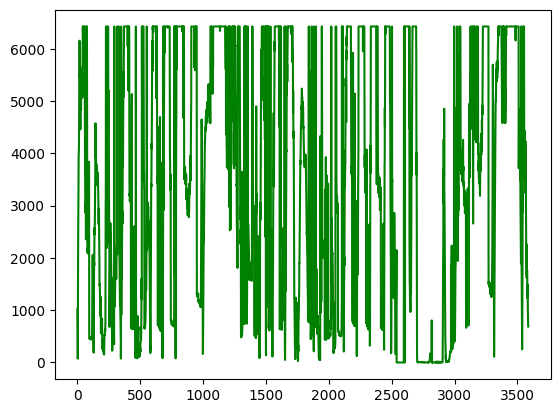

In [473]:
plt.plot(list(range(len(loss))), loss, color='green')

<Axes: xlabel='time_s_2', ylabel='params.accelRMS.x'>

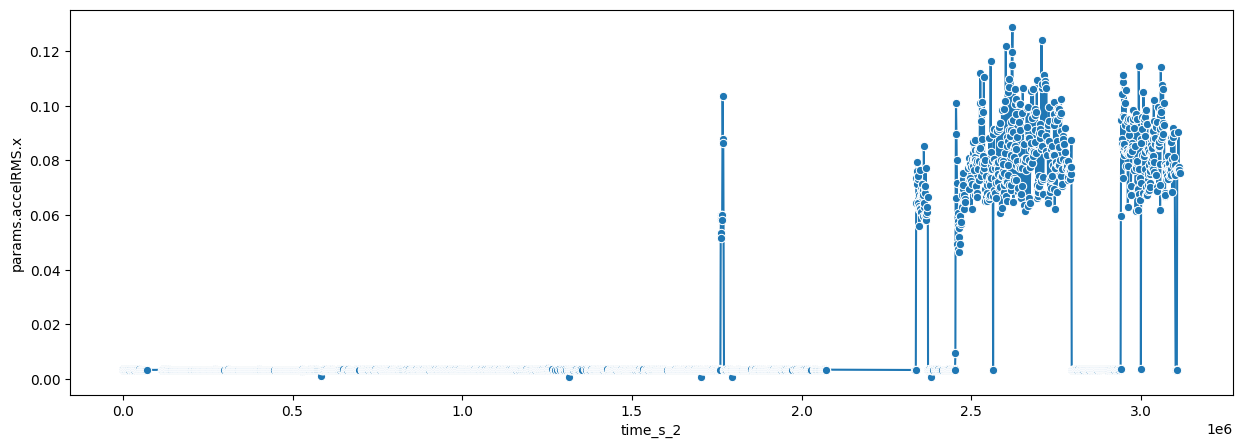

In [394]:
plt.subplots(figsize=(15, 5), sharey=False)
sns.lineplot(data['MZU6388'].df, x='time_s_2', y='params.accelRMS.x', marker='o')